In [1]:
import sqlite3
import pandas as pd
from IPython.display import display
import matplotlib.pyplot as plt
import ipywidgets as widgets
import seaborn as sns
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, classification_report
from sklearn.preprocessing import OneHotEncoder, label_binarize
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.exceptions import UndefinedMetricWarning
import warnings
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline as ImbPipeline
import random
from collections import defaultdict

warnings.filterwarnings("ignore", category=UndefinedMetricWarning)

# URLs dos arquivos CSV no GitHub
links_arquivos = {
    "tabela_ocupacao_trabalho_atualizado": "https://github.com/CamillaSemenzzatt/PROJETO-APLICADO-III/raw/main/tabela_ocupacao_trabalho_atualizado.csv",
    "tabela_posicao_categoria_atualizado": "https://github.com/CamillaSemenzzatt/PROJETO-APLICADO-III/raw/main/tabela_posicao_categoria_atualizado.csv",
    "tabela_genero_atualizado": "https://github.com/CamillaSemenzzatt/PROJETO-APLICADO-III/raw/main/tabela_genero_atualizado.csv",
    "tabela_escolaridade_atualizado": "https://github.com/CamillaSemenzzatt/PROJETO-APLICADO-III/raw/main/tabela_escolaridade_atualizado.csv",
    "tabela_posicao_atualizado": "https://github.com/CamillaSemenzzatt/PROJETO-APLICADO-III/raw/main/tabela_posicao_atualizado.csv",
    "tabela_condicao_atualizado": "https://github.com/CamillaSemenzzatt/PROJETO-APLICADO-III/raw/main/tabela_condicao_atualizado.csv",
    "tabela_idade_atualizado": "https://github.com/CamillaSemenzzatt/PROJETO-APLICADO-III/raw/main/tabela_idade_atualizado.csv",
}

tabelas = {}

# Dicionário para mapear nomes de municípios/capitais para estados
depara_municipios = {
    'Acre': 'Acre',
    'Alagoas': 'Alagoas',
    'Amapá': 'Amapá',
    'Amazonas': 'Amazonas',
    'Aracaju (SE)': 'Sergipe',
    'Bahia': 'Bahia',
    'Belo Horizonte (MG)': 'Minas Gerais',
    'Belém (PA)': 'Pará',
    'Boa Vista (RR)': 'Roraima',
    'Brasília (DF)': 'Distrito Federal',
    'Campo Grande (MS)': 'Mato Grosso do Sul',
    'Ceará': 'Ceará',
    'Cuiabá (MT)': 'Mato Grosso',
    'Curitiba (PR)': 'Paraná',
    'Distrito Federal': 'Distrito Federal',
    'Espírito Santo': 'Espírito Santo',
    'Florianópolis (SC)': 'Santa Catarina',
    'Fonte: IBGE - Pesquisa Nacional por Amostra de Domicílios Contínua trimestral': 'Fonte: IBGE - Pesquisa Nacional por Amostra de Domicílios Contínua trimestral',
    'Fortaleza (CE)': 'Ceará',
    'Goiás': 'Goiás',
    'Goiânia (GO)': 'Goiás',
    'João Pessoa (PB)': 'Paraíba',
    'Macapá (AP)': 'Amapá',
    'Maceió (AL)': 'Alagoas',
    'Manaus (AM)': 'Amazonas',
    'Maranhão': 'Maranhão',
    'Mato Grosso': 'Mato Grosso',
    'Mato Grosso do Sul': 'Mato Grosso do Sul',
    'Minas Gerais': 'Minas Gerais',
    'Natal (RN)': 'Rio Grande do Norte',
    'Palmas (TO)': 'Tocantins',
    'Paraná': 'Paraná',
    'Paraíba': 'Paraíba',
    'Pará': 'Pará',
    'Pernambuco': 'Pernambuco',
    'Piauí': 'Piauí',
    'Porto Alegre (RS)': 'Rio Grande do Sul',
    'Porto Velho (RO)': 'Rondônia',
    'Recife (PE)': 'Pernambuco',
    'Rio Branco (AC)': 'Acre',
    'Rio Grande do Norte': 'Rio Grande do Norte',
    'Rio Grande do Sul': 'Rio Grande do Sul',
    'Rio de Janeiro': 'Rio de Janeiro',
    'Rio de Janeiro (RJ)': 'Rio de Janeiro',
    'Rondônia': 'Rondônia',
    'Roraima': 'Roraima',
    'Salvador (BA)': 'Bahia',
    'Santa Catarina': 'Santa Catarina',
    'Sergipe': 'Sergipe',
    'São Luís (MA)': 'Maranhão',
    'São Paulo': 'São Paulo',
    'Vitória (ES)': 'Espírito Santo',
    'São Paulo (SP)': 'São Paulo',
    'Teresina (PI)': 'Piauí'
}

# --- Leitura dos arquivos CSV e aplicação do depara ---
for nome_tabela, link in links_arquivos.items():
    try:
        # Tenta ler como CSV primeiro
        df = pd.read_csv(link)
        tabelas[nome_tabela] = df
    except pd.errors.ParserError:
        # Se der erro, tenta ler como tabela separada por tabulações
        df = pd.read_csv(link, sep='\t')
        tabelas[nome_tabela] = df

    # Aplica o depara_municipios se a coluna 'municipio' existir
    if 'municipio' in tabelas[nome_tabela].columns:
        tabelas[nome_tabela]['municipio'] = tabelas[nome_tabela]['municipio'].replace(depara_municipios)

        # --- Criação do banco de dados SQLite e população das tabelas ---
db_name = "projeto_aplicado.db"
conn = sqlite3.connect(db_name)

for nome_tabela, tabela in tabelas.items():
    # Use o nome da tabela do dicionário para criar a tabela no banco de dados
    tabela.to_sql(nome_tabela, conn, if_exists='replace', index=False)
    print(f"Tabela '{nome_tabela}' criada e dados inseridos no banco de dados.")

conn.close()
print("Banco de dados populado com sucesso!")

# --- Verificação das tabelas e colunas no banco de dados (Opcional) ---
conn = sqlite3.connect(db_name)
cursor = conn.cursor()

cursor.execute("SELECT name FROM sqlite_master WHERE type='table';")
tabelas_no_db = cursor.fetchall()

print("\nTabelas no banco de dados:")
for tabela in tabelas_no_db:
    nome_tabela_db = tabela[0]
    print(f"- {nome_tabela_db}")

    cursor.execute(f"PRAGMA table_info({nome_tabela_db});")
    colunas = cursor.fetchall()

    print(f"  Colunas da tabela {nome_tabela_db}:")
    for coluna in colunas:
        print(f"    - {coluna[1]}") # coluna[1] contém o nome da coluna
print("\n")

conn.close()

#junção
# --- Definição das consultas SQL ---
query_3_juncoes = """
SELECT
    o.municipio,
    o.trimestre,
    o.`Ocupação no trabalho`,
    o.`quantidade de ocupação no trabalho`,
    pc.`Posição na ocupação`,
    pc.`quantidade de posição e categoria`,
    g.Sexo,
    g.`quantidade de gênero`
FROM
    tabela_ocupacao_trabalho_atualizado o
LEFT JOIN
    tabela_posicao_categoria_atualizado pc ON o.municipio = pc.municipio AND o.trimestre = pc.trimestre
LEFT JOIN
    tabela_genero_atualizado g ON o.municipio = g.municipio AND o.trimestre = g.trimestre;
"""

query_4_juncoes = """
SELECT
    e.municipio,
    e.trimestre,
    e.`Nivel de Instrução` AS nivel_instrucao,
    e.`quantidade de escolaridade` AS quantidade_escolaridade,
    p.`posição de ocupação`,
    p.`quantidade de posição de ocupação`,
    c.`Condição de ocupação`,
    c.`quantidade de condição de ocupação`,
    i.Grupo AS grupo_etario,
    i.`quantidade de idade`
FROM
    tabela_escolaridade_atualizado e
LEFT JOIN
    tabela_posicao_atualizado p ON e.municipio = p.municipio AND e.trimestre = p.trimestre
LEFT JOIN
    tabela_condicao_atualizado c ON e.municipio = c.municipio AND e.trimestre = c.trimestre
LEFT JOIN
    tabela_idade_atualizado i ON e.municipio = i.municipio AND e.trimestre = i.trimestre;
"""

# --- Função para executar a consulta ---
def executar_consulta(query, db_name):
    conn = sqlite3.connect(db_name)
    df = pd.read_sql_query(query, conn)
    conn.close()
    return df

# --- Execução das consultas e exibição dos resultados ---
print("Executando consulta com 3 junções...")
df_3_juncoes = executar_consulta(query_3_juncoes, db_name)
print("Resultado da consulta com 3 junções:")
display(df_3_juncoes)

print("\nExecutando consulta com 4 junções...")
df_4_juncoes = executar_consulta(query_4_juncoes, db_name)
print("Resultado da consulta com 4 junções:")
display(df_4_juncoes)

print("\nProcesso concluído.")

Tabela 'tabela_ocupacao_trabalho_atualizado' criada e dados inseridos no banco de dados.
Tabela 'tabela_posicao_categoria_atualizado' criada e dados inseridos no banco de dados.
Tabela 'tabela_genero_atualizado' criada e dados inseridos no banco de dados.
Tabela 'tabela_escolaridade_atualizado' criada e dados inseridos no banco de dados.
Tabela 'tabela_posicao_atualizado' criada e dados inseridos no banco de dados.
Tabela 'tabela_condicao_atualizado' criada e dados inseridos no banco de dados.
Tabela 'tabela_idade_atualizado' criada e dados inseridos no banco de dados.
Banco de dados populado com sucesso!

Tabelas no banco de dados:
- tabela_ocupacao_trabalho_atualizado
  Colunas da tabela tabela_ocupacao_trabalho_atualizado:
    - municipio
    - trimestre
    - Ocupação no trabalho
    - quantidade de ocupação no trabalho
- tabela_posicao_categoria_atualizado
  Colunas da tabela tabela_posicao_categoria_atualizado:
    - municipio
    - trimestre
    - Posição na ocupação
    - quant

,municipio,trimestre,Ocupação no trabalho,quantidade de ocupação no trabalho,Posição na ocupação,quantidade de posição e categoria,Sexo,quantidade de gênero
0,Rondônia,1º trimestre 2012,"Agricultura, pecuária, produção florestal, pes...",149.0,Conta própria,195.0,Homens,173.0
1,Rondônia,1º trimestre 2012,"Agricultura, pecuária, produção florestal, pes...",149.0,Conta própria,195.0,Mulheres,168.0
2,Rondônia,1º trimestre 2012,"Agricultura, pecuária, produção florestal, pes...",149.0,"Empregado no setor privado, exclusive trabalha...",291.0,Homens,173.0
3,Rondônia,1º trimestre 2012,"Agricultura, pecuária, produção florestal, pes...",149.0,"Empregado no setor privado, exclusive trabalha...",291.0,Mulheres,168.0
4,Rondônia,1º trimestre 2012,"Agricultura, pecuária, produção florestal, pes...",149.0,"Empregado no setor privado, exclusive trabalha...",205.0,Homens,173.0
...,...,...,...,...,...,...,...,...
438043,Distrito Federal,4º trimestre 2024,Atividades mal definidas,0.0,Trabalhador doméstico - com carteira de trabal...,30.0,Mulheres,1377.0
438044,Distrito Federal,4º trimestre 2024,Atividades mal definidas,0.0,Trabalhador doméstico - sem carteira de trabal...,53.0,Homens,1253.0
438045,Distrito Federal,4º trimestre 2024,Atividades mal definidas,0.0,Trabalhador doméstico - sem carteira de trabal...,53.0,Mulheres,1377.0
438046,Distrito Federal,4º trimestre 2024,Atividades mal definidas,0.0,Trabalhador familiar auxiliar,7.0,Homens,1253.0



Executando consulta com 4 junções...
Resultado da consulta com 4 junções:


,municipio,trimestre,nivel_instrucao,quantidade_escolaridade,posição de ocupação,quantidade de posição de ocupação,Condição de ocupação,quantidade de condição de ocupação,grupo_etario,quantidade de idade
0,Rondônia,1º trimestre 2012,Sem instrução e menos de 1 ano de estudo,13.0,Conta própria,46.0,Fora da força de trabalho,120,14 a 17 anos,38.0
1,Rondônia,1º trimestre 2012,Sem instrução e menos de 1 ano de estudo,13.0,Conta própria,46.0,Fora da força de trabalho,120,18 a 24 anos,60.0
2,Rondônia,1º trimestre 2012,Sem instrução e menos de 1 ano de estudo,13.0,Conta própria,46.0,Fora da força de trabalho,120,25 a 39 anos,123.0
3,Rondônia,1º trimestre 2012,Sem instrução e menos de 1 ano de estudo,13.0,Conta própria,46.0,Fora da força de trabalho,120,40 a 59 anos,94.0
4,Rondônia,1º trimestre 2012,Sem instrução e menos de 1 ano de estudo,13.0,Conta própria,46.0,Fora da força de trabalho,120,60 anos ou mais,26.0
...,...,...,...,...,...,...,...,...,...,...
898395,Distrito Federal,4º trimestre 2024,Não determinado,0.0,Trabalhador familiar auxiliar,7.0,Força de trabalho - ocupada,1606,14 a 17 anos,190.0
898396,Distrito Federal,4º trimestre 2024,Não determinado,0.0,Trabalhador familiar auxiliar,7.0,Força de trabalho - ocupada,1606,18 a 24 anos,328.0
898397,Distrito Federal,4º trimestre 2024,Não determinado,0.0,Trabalhador familiar auxiliar,7.0,Força de trabalho - ocupada,1606,25 a 39 anos,805.0
898398,Distrito Federal,4º trimestre 2024,Não determinado,0.0,Trabalhador familiar auxiliar,7.0,Força de trabalho - ocupada,1606,40 a 59 anos,872.0



Processo concluído.


In [2]:
print("\n--- Treinamento de Modelo de Classificação (RandomForestClassifier) com Amostra Reduzida ---")

# 1. Definir a Tarefa, Features (X) e Target (y)
target_classificacao = 'Condição de ocupação'

features_classificacao = [
    'municipio',
    'trimestre',
    'nivel_instrucao',
    'posição de ocupação',
    'grupo_etario',
    'quantidade_escolaridade',
    'quantidade de posição de ocupação',
    'quantidade de idade',
    'quantidade de condição de ocupação'
]

colunas_necessarias_classificacao = features_classificacao + [target_classificacao]

if all(col in df_4_juncoes.columns for col in colunas_necessarias_classificacao):

    df_modelo_classificacao = df_4_juncoes[colunas_necessarias_classificacao].copy()
    df_modelo_classificacao.dropna(subset=[target_classificacao], inplace=True)

    if df_modelo_classificacao.empty:
        print("DataFrame vazio após remover valores ausentes no target. Não é possível treinar o modelo.")
    else:
        X = df_modelo_classificacao.drop(target_classificacao, axis=1)
        y = df_modelo_classificacao[target_classificacao]

        # --- ADICIONANDO AMOSTRAGEM AQUI ---
        fracao_amostra = 0.1 # Ajuste este valor conforme necessário

        print(f"\nUsando uma amostra de {fracao_amostra*100:.0f}% dos dados para testes rápidos.")

        try:
             X_amostra, _, y_amostra, _ = train_test_split(X, y, train_size=fracao_amostra, random_state=42, stratify=y)
             print("Amostragem estratificada realizada com sucesso.")
        except ValueError as e:
             print(f"Erro ao realizar amostragem estratificada na amostra inicial: {e}. Tentando amostragem aleatória simples...")
             df_amostra = df_modelo_classificacao.sample(frac=fracao_amostra, random_state=42).copy()
             X_amostra = df_amostra.drop(target_classificacao, axis=1)
             y_amostra = df_amostra[target_classificacao]

        print(f"Tamanho da amostra total: {len(X_amostra)} amostras")
        # --- FIM DA ADIÇÃO DA AMOSTRAGEM ---

        colunas_categoricas = X_amostra.select_dtypes(include=['object', 'category']).columns.tolist()
        colunas_numericas = X_amostra.select_dtypes(include=np.number).columns.tolist()

        # 2. Pré-processar Dados usando Pipelines e ColumnTransformer - Usando a amostra
        preprocessor = ColumnTransformer(
            transformers=[
                ('num', 'passthrough', colunas_numericas),
                ('cat', OneHotEncoder(handle_unknown='ignore'), colunas_categoricas)
            ],
            remainder='passthrough'
        )

        # 3. Dividir a Amostra em Treino e Teste
        try:
            X_treino, X_teste, y_treino, y_teste = train_test_split(X_amostra, y_amostra, test_size=0.20, random_state=42, stratify=y_amostra)
        except ValueError as e:
            print(f"Erro ao dividir a amostra de treino/teste com stratify: {e}")
            print("Isso pode ocorrer se alguma classe na amostra tiver apenas uma amostra.")
            print("Tentando dividir a amostra sem stratify...")
            X_treino, X_teste, y_treino, y_teste = train_test_split(X_amostra, y_amostra, test_size=0.20, random_state=42)

        print(f"Tamanho do conjunto de treino (amostra): {len(X_treino)} amostras")
        print(f"Tamanho do conjunto de teste (amostra): {len(X_teste)} amostras")

        # 4. Definir Pipeline para RandomForestClassifier com SMOTE
        pipeline_rf = ImbPipeline(steps=[
            ('preprocessor', preprocessor),
            ('smote', SMOTE(random_state=42)),
            ('classifier', RandomForestClassifier(random_state=42))
        ])

        # 5. Treinar o Modelo (Diretamente o Pipeline)
        print("\nTreinando o Pipeline (RandomForestClassifier com SMOTE) diretamente...")
        try:
            pipeline_rf.fit(X_treino, y_treino)
            print("Fit do Pipeline concluído.")

            # --- Gerar Previsões no conjunto de teste ---
            y_pred_rf = pipeline_rf.predict(X_teste)
            print("\nPrevisões geradas para o conjunto de teste.")

            # --- Avaliar o Modelo ---
            print("\nMétricas de Avaliação no Conjunto de Teste:")

            # Acurácia
            accuracy = accuracy_score(y_teste, y_pred_rf)
            print(f"  Acurácia: {accuracy:.2f}")

            # Precisão, Revocação e F1-Score
            try:
                precision = precision_score(y_teste, y_pred_rf, average='weighted')
                recall = recall_score(y_teste, y_pred_rf, average='weighted')
                f1 = f1_score(y_teste, y_pred_rf, average='weighted')

                print(f"  Precisão (Weighted): {precision:.2f}")
                print(f"  Revocação (Weighted): {recall:.2f}")
                print(f"  F1-Score (Weighted): {f1:.2f}")

                # Relatório de Classificação completo
                print("\nRelatório de Classificação:")
                print(classification_report(y_teste, y_pred_rf))

            except ValueError as e:
                 print(f"Erro ao calcular métricas de Precisão, Revocação ou F1-Score: {e}")
                 print("Isso pode ocorrer se as previsões não contiverem todas as classes presentes nos valores reais de teste.")

            # AUC-ROC
            if hasattr(pipeline_rf, 'predict_proba'):
                try:
                    y_prob_rf = pipeline_rf.predict_proba(X_teste)
                    classes_na_amostra_total = np.unique(y_amostra)
                    y_teste_bin = label_binarize(y_teste, classes=classes_na_amostra_total)
                    n_classes = y_teste_bin.shape[1]

                    if n_classes > 1:
                         auc_roc = roc_auc_score(y_teste_bin, y_prob_rf, average='weighted')
                         print(f"  AUC-ROC (Weighted OvR): {auc_roc:.2f}")
                    else:
                         print("  AUC-ROC não calculado: Apenas uma classe presente nos dados de teste.")
                except Exception as e:
                     print(f"Erro ao calcular AUC-ROC: {e}")
                     print("Verifique se y_prob_rf foi gerado corretamente e se há mais de uma classe no conjunto de teste.")
            else:
                print("\nModelo não suporta predict_proba, AUC-ROC não calculado.")

        except Exception as e:
            print(f"\nErro durante o treinamento do Pipeline: {e}")
            print("O Pipeline não completou o treinamento.")

else:
    print("Algumas colunas necessárias para o modelo de classificação não foram encontradas em df_4_juncoes.")


--- Treinamento de Modelo de Classificação (RandomForestClassifier) com Amostra Reduzida ---

Usando uma amostra de 10% dos dados para testes rápidos.
Amostragem estratificada realizada com sucesso.
Tamanho da amostra total: 89840 amostras
Tamanho do conjunto de treino (amostra): 71872 amostras
Tamanho do conjunto de teste (amostra): 17968 amostras

Treinando o Pipeline (RandomForestClassifier com SMOTE) diretamente...
Fit do Pipeline concluído.

Previsões geradas para o conjunto de teste.

Métricas de Avaliação no Conjunto de Teste:
  Acurácia: 0.82
  Precisão (Weighted): 0.82
  Revocação (Weighted): 0.82
  F1-Score (Weighted): 0.82

Relatório de Classificação:
                                precision    recall  f1-score   support

     Fora da força de trabalho       0.86      0.87      0.87      4489
             Força de trabalho       0.76      0.77      0.76      4493
Força de trabalho - desocupada       0.88      0.88      0.88      4493
   Força de trabalho - ocupada       0.

In [3]:
# --- Função para recomendar programas sociais com porcentagem e gráfico (Sistema de Recomendação) ---
def sistema_recomendacao_porcentagem(municipio, trimestre, df_3_juncoes, df_4_juncoes):
    """
    Sistema de recomendação que sugere programas sociais com base nas características
    do município e trimestre, calcula a porcentagem de potenciais beneficiários
    e exibe um gráfico.

    Retorna uma lista de programas recomendados ordenados pela porcentagem de
    potenciais beneficiários.
    """

    dados_municipio_3 = df_3_juncoes[(df_3_juncoes["municipio"] == municipio) & (df_3_juncoes["trimestre"] == trimestre)].copy()
    dados_municipio_4 = df_4_juncoes[(df_4_juncoes["municipio"] == municipio) & (df_4_juncoes["trimestre"] == trimestre)].copy()

    if dados_municipio_3.empty and dados_municipio_4.empty:
        print(f"Nenhum dado disponível para o município: {municipio} no trimestre: {trimestre}")
        return [] # Retorna lista vazia se não houver dados

    print(f"\nAnálise para o município: {municipio} no trimestre: {trimestre}")

    total_pessoas = dados_municipio_4["quantidade de idade"].sum()

    if total_pessoas == 0:
        print("Não há registros suficientes para calcular porcentagens de beneficiários para programas sociais.")
        return [] # Retorna lista vazia se total de pessoas for zero

    porcentagens = {}

    # --- Cálculo de Porcentagens por Programa ---

    # Minha Casa Minha Vida
    if "grupo_etario" in dados_municipio_4.columns:
        beneficiarios_mcmv = dados_municipio_4.loc[dados_municipio_4["grupo_etario"] == "25 a 39 anos", "quantidade de idade"].sum()
        if beneficiarios_mcmv > 0:
            porcentagem_mcmv = (beneficiarios_mcmv / total_pessoas) * 100
            porcentagens["Minha Casa Minha Vida"] = porcentagem_mcmv

    # Auxílio Emergencial
    if "grupo_etario" in dados_municipio_4.columns and "Condição de ocupação" in dados_municipio_4.columns:
        condicao_idade = dados_municipio_4["grupo_etario"].isin(["18 a 24 anos", "25 a 39 anos", "40 a 59 anos"])
        condicao_ocupacao = dados_municipio_4["Condição de ocupação"].str.contains("Fora da força de trabalho", na=False)
        beneficiarios_emergencial_df = dados_municipio_4.loc[condicao_idade & condicao_ocupacao]
        beneficiarios_emergencial = beneficiarios_emergencial_df["quantidade de idade"].sum()

        if beneficiarios_emergencial > 0:
            porcentagem_emergencial = (beneficiarios_emergencial / total_pessoas) * 100
            porcentagens["Auxílio Emergencial"] = porcentagem_emergencial

    # BPC (Benefício de Prestação Continuada)
    if "grupo_etario" in dados_municipio_4.columns or "Condição de ocupação" in dados_municipio_4.columns:
        beneficiarios_idosos = 0
        if "grupo_etario" in dados_municipio_4.columns:
            beneficiarios_idosos = dados_municipio_4.loc[dados_municipio_4["grupo_etario"] == "60 anos ou mais", "quantidade de idade"].sum()

        beneficiarios_deficiencia = 0
        if "Condição de ocupação" in dados_municipio_4.columns:
             if 'quantidade de condição de ocupação' in dados_municipio_4.columns:
                  beneficiarios_deficiencia = dados_municipio_4.loc[dados_municipio_4["Condição de ocupação"].str.contains("Pessoas com deficiência", na=False), 'quantidade de condição de ocupação'].sum()
             else:
                  beneficiarios_deficiencia = dados_municipio_4.loc[dados_municipio_4["Condição de ocupação"].str.contains("Pessoas com deficiência", na=False), 'quantidade de idade'].sum()

        total_beneficiarios_bpc = beneficiarios_idosos + beneficiarios_deficiencia

        if total_beneficiarios_bpc > 0:
            porcentagem_bpc = (total_beneficiarios_bpc / total_pessoas) * 100
            porcentagens["BPC"] = porcentagem_bpc

    # Programas para jovens (18 a 24 anos)
    if "grupo_etario" in dados_municipio_4.columns:
        beneficiarios_jovens = dados_municipio_4.loc[dados_municipio_4["grupo_etario"] == "18 a 24 anos", "quantidade de idade"].sum()
        if beneficiarios_jovens > 0:
            porcentagem_jovens = (beneficiarios_jovens / total_pessoas) * 100
            porcentagens["Programas para jovens"] = porcentagem_jovens

    # Brasil Alfabetizado
    if "nivel_instrucao" in dados_municipio_4.columns:
        beneficiarios_alfabetizacao = dados_municipio_4.loc[dados_municipio_4["nivel_instrucao"] == "Ensino fundamental incompleto ou equivalente", "quantidade_escolaridade"].sum()
        if beneficiarios_alfabetizacao > 0:
            porcentagem_alfabetizacao = (beneficiarios_alfabetizacao / total_pessoas) * 100
            porcentagens["Brasil Alfabetizado"] = porcentagem_alfabetizacao

    # Qualifica Mais
    if "Ocupação no trabalho" in dados_municipio_3.columns:
        condicao_qualifica = dados_municipio_3["Ocupação no trabalho"].str.contains("Trabalhadores de serviços, vendedores do comércio em lojas e mercados|Trabalhadores da produção de bens e serviços industriais", na=False, regex=True)
        beneficiarios_qualifica = dados_municipio_3.loc[condicao_qualifica, "quantidade de ocupação no trabalho"].sum()

        if beneficiarios_qualifica > 0:
             porcentagem_qualifica = (beneficiarios_qualifica / total_pessoas) * 100
             porcentagens["Qualifica Mais"] = porcentagem_qualifica


    # --- Exibição das Porcentagens e Gráfico ---
    if not porcentagens:
        print("\nNenhum programa social recomendado com base nos dados disponíveis para este município e trimestre.")
        return [] # Retorna lista vazia se não houver porcentagens

    print("\nPotenciais Programas Sociais e Porcentagem de Beneficiários:")
    # Ordena os programas por porcentagem
    programas_ordenados = sorted(porcentagens.items(), key=lambda item: item[1], reverse=True)

    for programa, percentual in programas_ordenados:
         print(f"- {programa}: {percentual:.2f}% das pessoas se enquadram nos critérios.")

    # Gera o gráfico
    if porcentagens:
        programas = [item[0] for item in programas_ordenados]
        percentuais = [item[1] for item in programas_ordenados]

        plt.figure(figsize=(14, 7))
        plt.bar(programas, percentuais, color='#2E8B57')
        plt.ylabel("Porcentagem de Pessoas Potencialmente Beneficiadas (%)")
        plt.title(f"Porcentagem de Pessoas Potencialmente Beneficiadas por Programa Social\n em {municipio} no {trimestre}")
        plt.xticks(rotation=45, ha='right')
        plt.ylim(0, 100)
        plt.grid(axis='y', linestyle='--', alpha=0.7)
        plt.tight_layout()
        plt.show()

    # Retorna a lista de programas recomendados ordenados
    return [programa for programa, _ in programas_ordenados]

Função 'calcular_relevancia_real' não encontrada. Execute a célula onde ela foi definida.


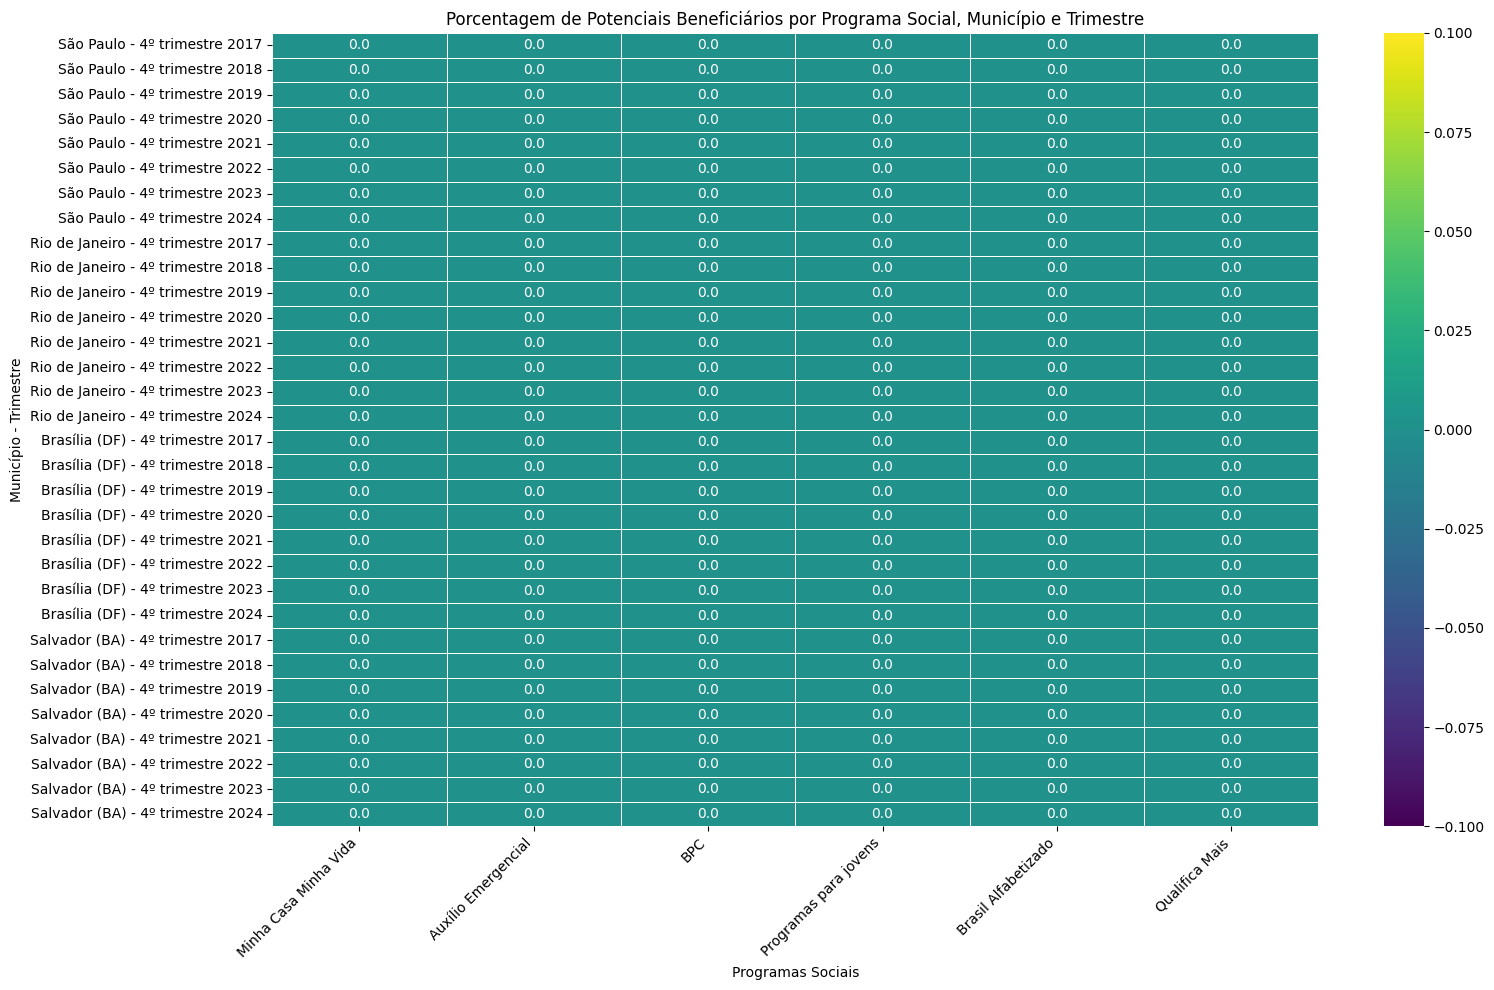

In [11]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# --- Configurações para o Mapa de Calor ---
# Selecione os municípios que você quer incluir no mapa de calor
municipios_para_heatmap = ['São Paulo', 'Rio de Janeiro', 'Brasília (DF)', 'Salvador (BA)'] # Exemplo, substitua pelos seus

# Selecione os trimestres que você quer incluir (pode ser todos ou um subconjunto)
# Vamos pegar os últimos alguns trimestres para demonstração
todos_trimestres_ordenados = sorted(df_4_juncoes['trimestre'].dropna().unique())
trimestres_para_heatmap = todos_trimestres_ordenados[-8:] # Exemplo: últimos 8 trimestres

# Lista de todos os programas sociais
todos_programas = [
    "Minha Casa Minha Vida",
    "Auxílio Emergencial",
    "BPC",
    "Programas para jovens",
    "Brasil Alfabetizado",
    "Qualifica Mais"
]

# --- Preparar os dados para o Mapa de Calor ---
# Vamos criar um dataframe que terá municípios/trimestres como índice e programas como colunas
heatmap_data = pd.DataFrame(index=[f"{m} - {t}" for m in municipios_para_heatmap for t in trimestres_para_heatmap],
                            columns=todos_programas)

# Preencher o dataframe com as porcentagens de elegibilidade
if 'calcular_relevancia_real' in globals(): # Reutiliza a função para calcular a porcentagem
    for municipio in municipios_para_heatmap:
        for trimestre in trimestres_para_heatmap:
            id_municipio_trimestre = f"{municipio} - {trimestre}"
            for programa in todos_programas:
                # Calcular a porcentagem de elegibilidade (usando limiar 0 para obter a porcentagem real)
                porcentagem_elegibilidade = calcular_relevancia_real(
                    municipio,
                    trimestre,
                    programa,
                    df_3_juncoes,
                    df_4_juncoes,
                    0 # Usamos limiar 0 para obter a porcentagem real
                )
                # Armazenar a porcentagem no dataframe do heatmap
                heatmap_data.loc[id_municipio_trimestre, programa] = porcentagem_elegibilidade
else:
    print("Função 'calcular_relevancia_real' não encontrada. Execute a célula onde ela foi definida.")


# Converter os dados para tipo numérico (podem ter vindo como object)
heatmap_data = heatmap_data.astype(float)

# Lidar com valores ausentes no dataframe do heatmap (pode acontecer se não houver dados para a combinação)
heatmap_data.fillna(0, inplace=True) # Preenche NaN com 0 (ou outro valor apropriado)

# --- Gerar o Mapa de Calor ---
if not heatmap_data.empty:
    plt.figure(figsize=(16, 10)) # Ajuste o tamanho conforme necessário
    sns.heatmap(heatmap_data, annot=True, fmt=".1f", cmap="viridis", linewidths=.5)
    plt.title("Porcentagem de Potenciais Beneficiários por Programa Social, Município e Trimestre")
    plt.xlabel("Programas Sociais")
    plt.ylabel("Município - Trimestre")
    plt.xticks(rotation=45, ha='right')
    plt.yticks(rotation=0)
    plt.tight_layout()
    plt.show()
else:
    print("DataFrame para o mapa de calor está vazio. Verifique os municípios e trimestres selecionados.")

In [7]:
# --- Funções para Baseline de Popularidade ---

def get_all_possible_programs():
    """Retorna uma lista de todos os programas sociais potenciais que a função de recomendação considera."""
    return [
        "Minha Casa Minha Vida",
        "Auxílio Emergencial",
        "BPC",
        "Programas para jovens",
        "Brasil Alfabetizado",
        "Qualifica Mais"
    ]

def calculate_program_popularity(df_3_juncoes, df_4_juncoes):
    """Calcula a porcentagem média de potenciais beneficiários para cada programa em todos os dados."""
    program_total_beneficiaries = defaultdict(float)
    program_total_population = defaultdict(float)
    program_count = defaultdict(int)

    combinacoes_unicas_3 = df_3_juncoes[['municipio', 'trimestre']].drop_duplicates()
    combinacoes_unicas_4 = df_4_juncoes[['municipio', 'trimestre']].drop_duplicates()

    todas_combinacoes = pd.concat([combinacoes_unicas_3, combinacoes_unicas_4]).drop_duplicates().values.tolist()

    for municipio, trimestre in todas_combinacoes:
        dados_municipio_3 = df_3_juncoes[(df_3_juncoes["municipio"] == municipio) & (df_3_juncoes["trimestre"] == trimestre)].copy()
        dados_municipio_4 = df_4_juncoes[(df_4_juncoes["municipio"] == municipio) & (df_4_juncoes["trimestre"] == trimestre)].copy()

        if dados_municipio_3.empty and dados_municipio_4.empty:
            continue

        total_pessoas = dados_municipio_4["quantidade de idade"].sum()

        if total_pessoas == 0:
            continue

        # Minha Casa Minha Vida
        if "grupo_etario" in dados_municipio_4.columns:
            beneficiarios_mcmv = dados_municipio_4.loc[dados_municipio_4["grupo_etario"] == "25 a 39 anos", "quantidade de idade"].sum()
            if beneficiarios_mcmv > 0:
                 program_total_beneficiaries["Minha Casa Minha Vida"] += beneficiarios_mcmv
                 program_total_population["Minha Casa Minha Vida"] += total_pessoas
                 program_count["Minha Casa Minha Vida"] += 1

        # Auxílio Emergencial
        if "grupo_etario" in dados_municipio_4.columns and "Condição de ocupação" in dados_municipio_4.columns:
            condicao_idade = dados_municipio_4["grupo_etario"].isin(["18 a 24 anos", "25 a 39 anos", "40 a 59 anos"])
            condicao_ocupacao = dados_municipio_4["Condição de ocupação"].str.contains("Fora da força de trabalho", na=False)
            beneficiarios_emergencial_df = dados_municipio_4.loc[condicao_idade & condicao_ocupacao]
            beneficiarios_emergencial = beneficiarios_emergencial_df["quantidade de idade"].sum()

            if beneficiarios_emergencial > 0:
                program_total_beneficiaries["Auxílio Emergencial"] += beneficiarios_emergencial
                program_total_population["Auxílio Emergencial"] += total_pessoas
                program_count["Auxílio Emergencial"] += 1

        # BPC (Benefício de Prestação Continuada)
        if "grupo_etario" in dados_municipio_4.columns or "Condição de ocupação" in dados_municipio_4.columns:
            beneficiarios_idosos = 0
            if "grupo_etario" in dados_municipio_4.columns:
                beneficiarios_idosos = dados_municipio_4.loc[dados_municipio_4["grupo_etario"] == "60 anos ou mais", "quantidade de idade"].sum()

            beneficiarios_deficiencia = 0
            if "Condição de ocupação" in dados_municipio_4.columns:
                 if 'quantidade de condição de ocupação' in dados_municipio_4.columns:
                      beneficiarios_deficiencia = dados_municipio_4.loc[dados_municipio_4["Condição de ocupação"].str.contains("Pessoas com deficiência", na=False), 'quantidade de condição de ocupação'].sum()
                 else:
                      beneficiarios_deficiencia = dados_municipio_4.loc[dados_municipio_4["Condição de ocupação"].str.contains("Pessoas com deficiência", na=False), 'quantidade de idade'].sum()

            total_beneficiarios_bpc = beneficiarios_idosos + beneficiarios_deficiencia

            if total_beneficiarios_bpc > 0:
                program_total_beneficiaries["BPC"] += total_beneficiarios_bpc
                program_total_population["BPC"] += total_pessoas
                program_count["BPC"] += 1

        # Programas para jovens (18 a 24 anos)
        if "grupo_etario" in dados_municipio_4.columns:
            beneficiarios_jovens = dados_municipio_4.loc[dados_municipio_4["grupo_etario"] == "18 a 24 anos", "quantidade de idade"].sum()
            if beneficiarios_jovens > 0:
                program_total_beneficiaries["Programas para jovens"] += beneficiarios_jovens
                program_total_population["Programas para jovens"] += total_pessoas
                program_count["Programas para jovens"] += 1

        # Brasil Alfabetizado
        if "nivel_instrucao" in dados_municipio_4.columns:
            beneficiarios_alfabetizacao = dados_municipio_4.loc[dados_municipio_4["nivel_instrucao"] == "Ensino fundamental incompleto ou equivalente", "quantidade_escolaridade"].sum()
            if beneficiarios_alfabetizacao > 0:
                program_total_beneficiaries["Brasil Alfabetizado"] += beneficiarios_alfabetizacao
                program_total_population["Brasil Alfabetizado"] += total_pessoas
                program_count["Brasil Alfabetizado"] += 1

        # Qualifica Mais
        if "Ocupação no trabalho" in dados_municipio_3.columns:
            condicao_qualifica = dados_municipio_3["Ocupação no trabalho"].str.contains("Trabalhadores de serviços, vendedores do comércio em lojas e mercados|Trabalhadores da produção de bens e serviços industriais", na=False, regex=True)
            beneficiarios_qualifica = dados_municipio_3.loc[condicao_qualifica, "quantidade de ocupação no trabalho"].sum()

            if beneficiarios_qualifica > 0:
                 program_total_beneficiaries["Qualifica Mais"] += beneficiarios_qualifica
                 program_total_population["Qualifica Mais"] += total_pessoas
                 program_count["Qualifica Mais"] += 1

    popularity_scores = {}
    for program in get_all_possible_programs():
        if program_total_population[program] > 0:
            popularity_scores[program] = (program_total_beneficiaries[program] / program_total_population[program]) * 100
        else:
            popularity_scores[program] = 0

    return popularity_scores

def recommend_by_popularity(df_3_juncoes, df_4_juncoes):
    """Recomenda programas sociais com base na popularidade geral."""
    popularity_scores = calculate_program_popularity(df_3_juncoes, df_4_juncoes)

    print("\n--- Recomendação Baseada em Popularidade (Baseline) ---")
    if not popularity_scores:
        print("Não foi possível calcular a popularidade dos programas com os dados disponíveis.")
        return

    sorted_popularity = sorted(popularity_scores.items(), key=lambda item: item[1], reverse=True)

    print("\nProgramas Sociais Recomendados por Popularidade (Potenciais Beneficiários Médios):")
    for program, score in sorted_popularity:
        print(f"- {program}: {score:.2f}% (Média geral)")

# Execute o baseline de popularidade após carregar os dados
if 'df_3_juncoes' in globals() and 'df_4_juncoes' in globals():
    recommend_by_popularity(df_3_juncoes, df_4_juncoes)
else:
    print("\nDataFrames df_3_juncoes ou df_4_juncoes não encontrados. Carregue os dados primeiro para executar o baseline.")


--- Recomendação Baseada em Popularidade (Baseline) ---

Programas Sociais Recomendados por Popularidade (Potenciais Beneficiários Médios):
- Minha Casa Minha Vida: 30.97% (Média geral)
- Auxílio Emergencial: 18.96% (Média geral)
- BPC: 17.23% (Média geral)
- Programas para jovens: 13.88% (Média geral)
- Brasil Alfabetizado: 12.36% (Média geral)
- Qualifica Mais: 0.00% (Média geral)



--- Top 3 Programas Sociais por Popularidade (Baseline) ---


<ipython-input-8-327db32f6745>:19: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=percentuais, y=programas, palette='Greens_d')


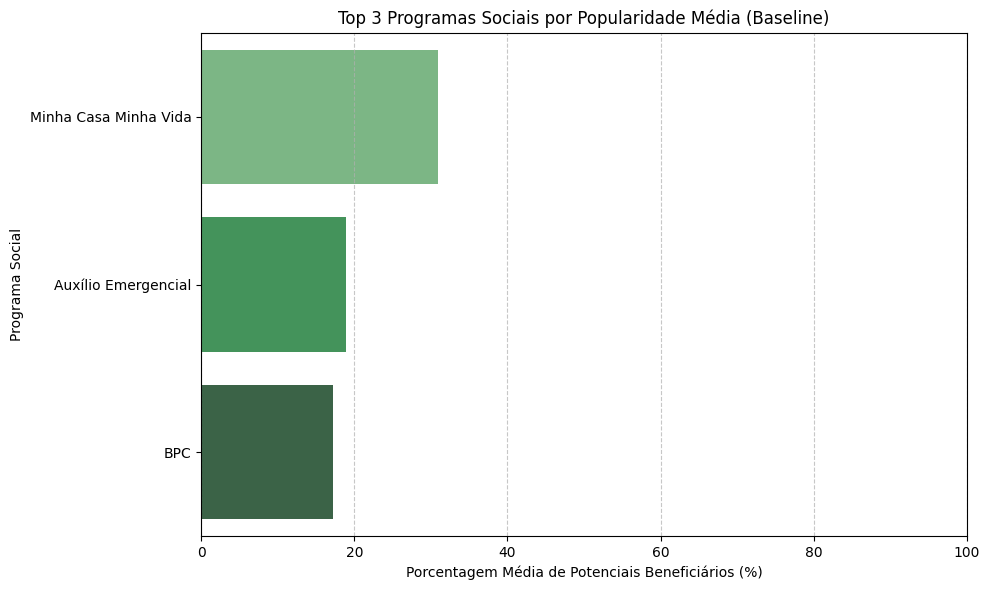

Gráfico dos Top 3 programas sociais por popularidade gerado.

Processo de geração do gráfico do Top 3 programas concluído.


In [8]:
# --- Etapa 13: Top 3 Programas Sociais por Popularidade (Baseline) ---
print("\n--- Top 3 Programas Sociais por Popularidade (Baseline) ---")

if 'df_3_juncoes' in globals() and 'df_4_juncoes' in globals():
    try:
        # Calcula a popularidade de todos os programas
        popularity_scores = calculate_program_popularity(df_3_juncoes, df_4_juncoes)

        if popularity_scores:
            # Ordena os programas por popularidade em ordem decrescente e pega o top 3
            sorted_popularity = sorted(popularity_scores.items(), key=lambda item: item[1], reverse=True)
            top_3_programas = sorted_popularity[:3]

            if top_3_programas:
                programas = [item[0] for item in top_3_programas]
                percentuais = [item[1] for item in top_3_programas]

                plt.figure(figsize=(10, 6))
                sns.barplot(x=percentuais, y=programas, palette='Greens_d')
                plt.xlabel("Porcentagem Média de Potenciais Beneficiários (%)")
                plt.ylabel("Programa Social")
                plt.title("Top 3 Programas Sociais por Popularidade Média (Baseline)")
                plt.xlim(0, 100) # Limita o eixo X a 100%
                plt.grid(axis='x', linestyle='--', alpha=0.7)
                plt.tight_layout()
                plt.show()
                print("Gráfico dos Top 3 programas sociais por popularidade gerado.")
            else:
                print("Não foi possível identificar os Top 3 programas com base na popularidade calculada.")

        else:
            print("Não foi possível calcular a popularidade dos programas para identificar o Top 3.")
    except Exception as e:
        print(f"Não foi possível gerar o gráfico do Top 3 programas. Erro: {e}")
else:
    print("\nDataFrames df_3_juncoes ou df_4_juncoes não encontrados. Não é possível gerar o gráfico do Top 3 programas.")

print("\nProcesso de geração do gráfico do Top 3 programas concluído.")

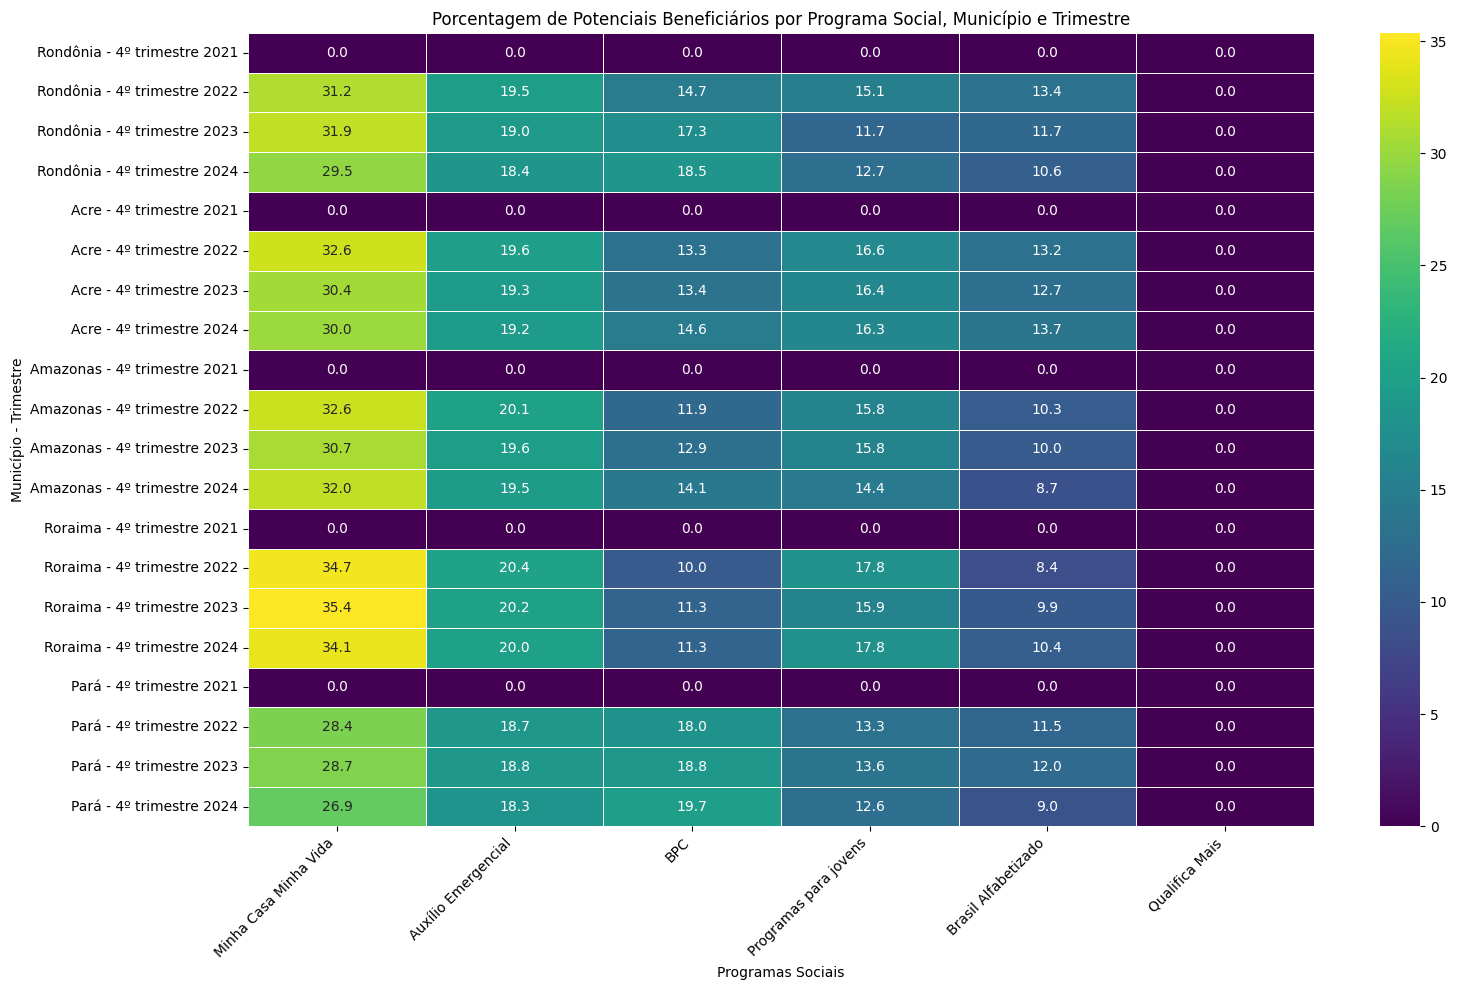

In [18]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# --- Função para calcular a porcentagem real de elegibilidade para um programa específico ---
def calcular_relevancia_real(municipio, trimestre, programa, df_3_juncoes, df_4_juncoes):
    """
    Calcula a porcentagem real de pessoas potencialmente elegíveis para um programa
    social específico em um dado município e trimestre.

    Args:
        municipio (str): O nome do município.
        trimestre (str): O trimestre.
        programa (str): O nome do programa social.
        df_3_juncoes (pd.DataFrame): DataFrame com 3 junções.
        df_4_juncoes (pd.DataFrame): DataFrame com 4 junções.

    Returns:
        float: A porcentagem de potenciais beneficiários. Retorna 0 se não houver dados
               ou total de pessoas for zero.
    """
    dados_municipio_3 = df_3_juncoes[(df_3_juncoes.get("municipio", "").str.contains(municipio, na=False)) & (df_3_juncoes.get("trimestre", "") == trimestre)].copy()
    dados_municipio_4 = df_4_juncoes[(df_4_juncoes.get("municipio", "").str.contains(municipio, na=False)) & (df_4_juncoes.get("trimestre", "") == trimestre)].copy()

    if dados_municipio_3.empty and dados_municipio_4.empty:
        return 0.0

    total_pessoas = dados_municipio_4.get("quantidade de idade", pd.Series(dtype=float)).sum()

    if total_pessoas <= 0:
        return 0.0

    beneficiarios = 0.0

    # --- Lógica para calcular beneficiários para cada programa ---
    if programa == "Minha Casa Minha Vida" and "grupo_etario" in dados_municipio_4.columns:
        beneficiarios = dados_municipio_4.loc[dados_municipio_4["grupo_etario"] == "25 a 39 anos", "quantidade de idade"].sum()
    elif programa == "Auxílio Emergencial" and "grupo_etario" in dados_municipio_4.columns and "Condição de ocupação" in dados_municipio_4.columns:
        condicao_idade = dados_municipio_4["grupo_etario"].isin(["18 a 24 anos", "25 a 39 anos", "40 a 59 anos"])
        condicao_ocupacao = dados_municipio_4["Condição de ocupação"].str.contains("Fora da força de trabalho", na=False)
        beneficiarios_emergencial_df = dados_municipio_4.loc[condicao_idade & condicao_ocupacao]
        beneficiarios = beneficiarios_emergencial_df.get("quantidade de idade", pd.Series(dtype=float)).sum()
    elif programa == "BPC" and ("grupo_etario" in dados_municipio_4.columns or "Condição de ocupação" in dados_municipio_4.columns):
        beneficiarios_idosos = 0
        if "grupo_etario" in dados_municipio_4.columns:
            beneficiarios_idosos = dados_municipio_4.loc[dados_municipio_4["grupo_etario"] == "60 anos ou mais", "quantidade de idade"].sum()
        beneficiarios_deficiencia = 0
        if "Condição de ocupação" in dados_municipio_4.columns:
             if 'quantidade de condição de ocupação' in dados_municipio_4.columns:
                  beneficiarios_deficiencia = dados_municipio_4.loc[dados_municipio_4["Condição de ocupação"].str.contains("Pessoas com deficiência", na=False), 'quantidade de condição de ocupação'].sum()
             else:
                  beneficiarios_deficiencia = dados_municipio_4.loc[dados_municipio_4["Condição de ocupação"].str.contains("Pessoas com deficiência", na=False), 'quantidade de idade'].sum()
        beneficiarios = beneficiarios_idosos + beneficiarios_deficiencia
    elif programa == "Programas para jovens" and "grupo_etario" in dados_municipio_4.columns:
        beneficiarios = dados_municipio_4.loc[dados_municipio_4["grupo_etario"] == "18 a 24 anos", "quantidade de idade"].sum()
    elif programa == "Brasil Alfabetizado" and "nivel_instrucao" in dados_municipio_4.columns:
        beneficiarios = dados_municipio_4.loc[dados_municipio_4["nivel_instrucao"] == "Ensino fundamental incompleto ou equivalente", "quantidade_escolaridade"].sum()
    elif programa == "Qualifica Mais" and "Ocupação no trabalho" in dados_municipio_3.columns:
        condicao_qualifica = dados_municipio_3["Ocupação no trabalho"].str.contains("Trabalhadores de serviços, vendedores do comércio em lojas e mercados|Trabalhadores da produção de bens e serviços industriais", na=False, regex=True)
        beneficiarios = dados_municipio_3.loc[condicao_qualifica, "quantidade de ocupação no trabalho"].sum()
    # Adicione lógica para outros programas aqui se necessário

    return (beneficiarios / total_pessoas) * 100 if total_pessoas > 0 else 0.0


# --- Configurações para o Mapa de Calor ---
# Selecione os municípios que você quer incluir no mapa de calor
# Obter uma lista dos 5 municípios com mais dados
if 'df_4_juncoes' in globals():
    top_municipios = df_4_juncoes['municipio'].value_counts().nlargest(5).index.tolist()
    municipios_para_heatmap = top_municipios if top_municipios else ['São Paulo', 'Rio de Janeiro'] # Fallback if no data
else:
    municipios_para_heatmap = ['São Paulo', 'Rio de Janeiro'] # Default if df_4_juncoes not available


# Selecione os trimestres que você quer incluir (pode ser todos ou um subconjunto)
# Vamos pegar os últimos 4 trimestres para demonstração
if 'df_4_juncoes' in globals():
    todos_trimestres_ordenados = sorted(df_4_juncoes['trimestre'].dropna().unique())
    trimestres_para_heatmap = todos_trimestres_ordenados[-4:] # Exemplo: últimos 4 trimestres
else:
    trimestres_para_heatmap = [] # Empty if df_4_juncoes not available

# Lista de todos os programas sociais que estamos considerando
todos_programas = [
    "Minha Casa Minha Vida",
    "Auxílio Emergencial",
    "BPC",
    "Programas para jovens",
    "Brasil Alfabetizado",
    "Qualifica Mais"
]

# --- Preparar os dados para o Mapa de Calor ---
# Crie um dataframe que terá municípios/trimestres como índice e programas como colunas
heatmap_data = pd.DataFrame(index=[f"{m} - {t}" for m in municipios_para_heatmap for t in trimestres_para_heatmap],
                            columns=todos_programas)

# Preencher o dataframe com as porcentagens de elegibilidade
if 'df_3_juncoes' in globals() and 'df_4_juncoes' in globals():
    for municipio in municipios_para_heatmap:
        for trimestre in trimestres_para_heatmap:
            id_municipio_trimestre = f"{municipio} - {trimestre}"
            for programa in todos_programas:
                # Calcular a porcentagem de elegibilidade
                porcentagem_elegibilidade = calcular_relevancia_real(
                    municipio,
                    trimestre,
                    programa,
                    df_3_juncoes,
                    df_4_juncoes
                )
                # Armazenar a porcentagem no dataframe do heatmap
                heatmap_data.loc[id_municipio_trimestre, programa] = porcentagem_elegibilidade

    # Converter os dados para tipo numérico (podem ter vindo como object)
    heatmap_data = heatmap_data.astype(float)

    # Lidar com valores ausentes no dataframe do heatmap (pode acontecer se não houver dados para a combinação)
    heatmap_data.fillna(0, inplace=True) # Preenche NaN com 0

    # --- Gerar o Mapa de Calor ---
    if not heatmap_data.empty:
        plt.figure(figsize=(16, 10)) # Ajuste o tamanho conforme necessário
        sns.heatmap(heatmap_data, annot=True, fmt=".1f", cmap="viridis", linewidths=.5)
        plt.title("Porcentagem de Potenciais Beneficiários por Programa Social, Município e Trimestre")
        plt.xlabel("Programas Sociais")
        plt.ylabel("Município - Trimestre")
        plt.xticks(rotation=45, ha='right')
        plt.yticks(rotation=0)
        plt.tight_layout()
        plt.show()
    else:
        print("DataFrame para o mapa de calor está vazio. Verifique os municípios e trimestres selecionados.")
else:
    print("DataFrames df_3_juncoes ou df_4_juncoes não encontrados. Carregue os dados primeiro para gerar o mapa de calor.")


--- Análise Detalhada para São Paulo no 1º trimestre 2023 ---

Vizinhos mais próximos de 'São Paulo - 1º trimestre 2023':
- São Paulo - 4º trimestre 2023 (Distância: 0.0001)
- São Paulo - 1º trimestre 2024 (Distância: 0.0002)
- São Paulo - 3º trimestre 2022 (Distância: 0.0003)
- São Paulo - 2º trimestre 2023 (Distância: 0.0003)

Sugestões de Programas Sociais (baseado nos vizinhos similares):
- Minha Casa Minha Vida: Média de 28.80% de elegibilidade nos vizinhos.
- BPC: Média de 21.59% de elegibilidade nos vizinhos.
- Auxílio Emergencial: Média de 18.14% de elegibilidade nos vizinhos.
- Programas para jovens: Média de 11.93% de elegibilidade nos vizinhos.
- Brasil Alfabetizado: Média de 9.96% de elegibilidade nos vizinhos.

--- Recomendação Baseada em Regras para São Paulo no 1º trimestre 2023 ---

--- Análise para o município: São Paulo no trimestre: 1º trimestre 2023 ---

Potenciais Programas Sociais e Porcentagem de Beneficiários (Trimestre Selecionado):
- Minha Casa Minha Vida: 29

<ipython-input-9-ec581753b470>:102: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=programas_trimestre, y=percentuais_trimestre, palette="viridis")


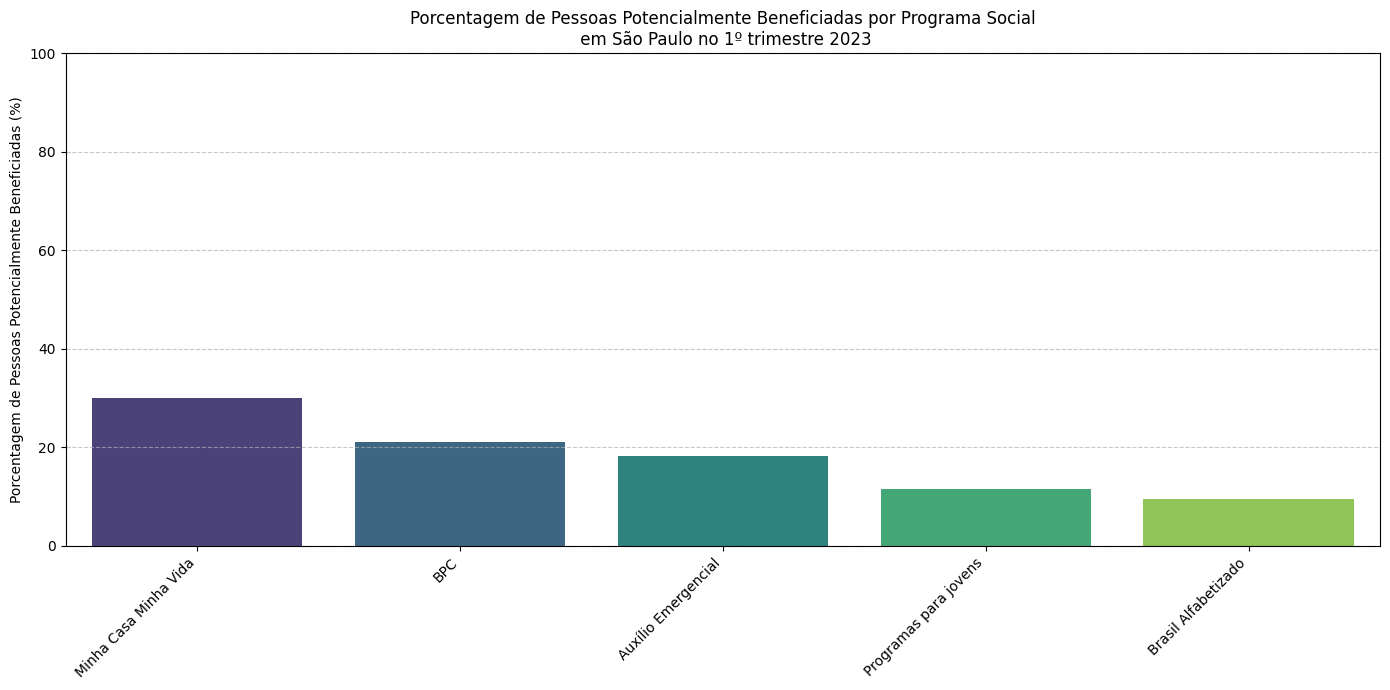


--- Análise de Tendência Histórica para o município: São Paulo ---

Tendência Histórica de Potenciais Beneficiários por Programa Social:
- Minha Casa Minha Vida: Média Histórica de 30.40% das pessoas se enquadram nos critérios.
- BPC: Média Histórica de 18.68% das pessoas se enquadram nos critérios.
- Auxílio Emergencial: Média Histórica de 18.66% das pessoas se enquadram nos critérios.
- Programas para jovens: Média Histórica de 12.89% das pessoas se enquadram nos critérios.
- Brasil Alfabetizado: Média Histórica de 11.78% das pessoas se enquadram nos critérios.
- Qualifica Mais: Média Histórica de 0.00% das pessoas se enquadram nos critérios.


<ipython-input-9-ec581753b470>:204: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=programas_hist, y=percentuais_hist, palette="viridis")


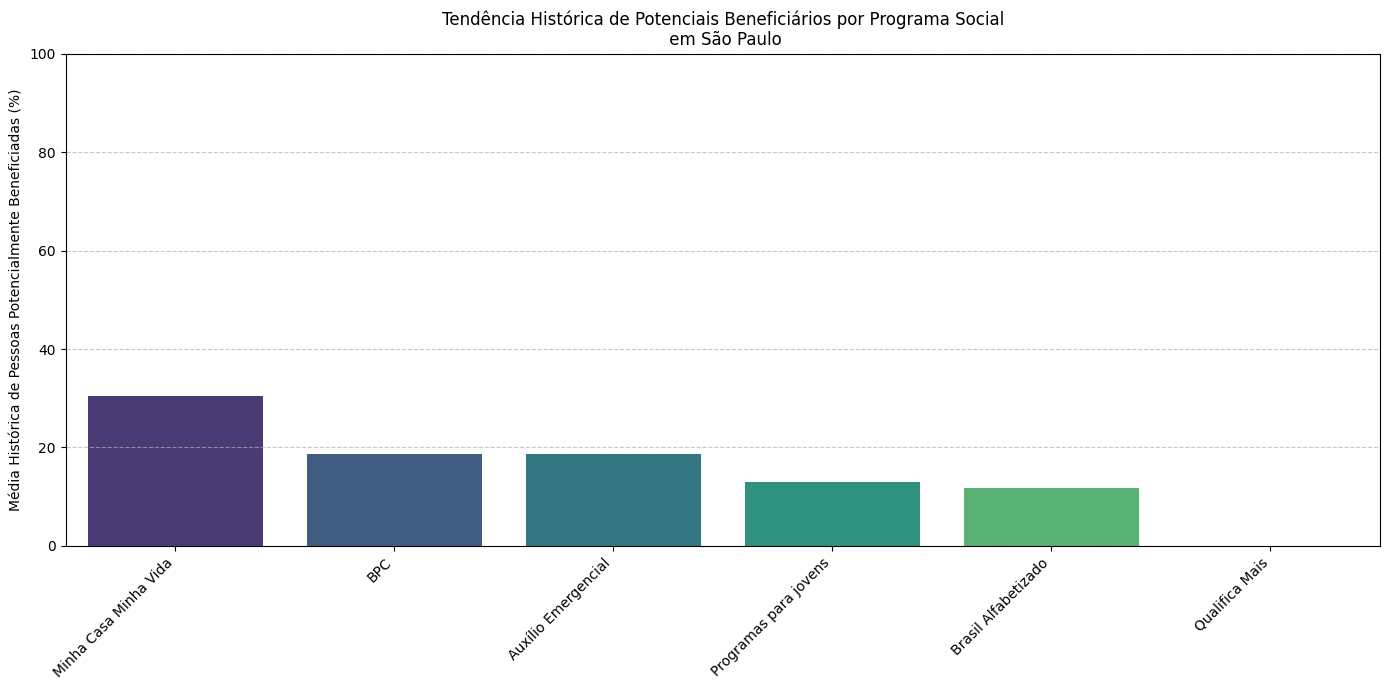

['Minha Casa Minha Vida',
 'BPC',
 'Auxílio Emergencial',
 'Programas para jovens',
 'Brasil Alfabetizado']

In [10]:
from sklearn.neighbors import NearestNeighbors
from sklearn.preprocessing import StandardScaler
import pandas as pd
import numpy as np

# modelo KNN
# Assumindo que df_4_juncoes é o dataframe com dados de município/trimestre
# Selecionar features numéricas para a similaridade
features_sim = [
    'quantidade_escolaridade',
    'quantidade de posição de ocupação',
    'quantidade de idade',
    'quantidade de condição de ocupação' # Pode precisar de tratamento se for string
]

# Adicionar features categóricas após one-hot encoding
colunas_categoricas_sim = ['nivel_instrucao', 'posição de ocupação', 'grupo_etario', 'Condição de ocupação']

# Combinar dados relevantes para a análise de similaridade
# Crie uma cópia para evitar SettingWithCopyWarning
df_sim = df_4_juncoes[['municipio', 'trimestre'] + features_sim + colunas_categoricas_sim].copy()

# Lidar com valores ausentes, se houver
df_sim.dropna(subset=features_sim + colunas_categoricas_sim, inplace=True)

if df_sim.empty:
    print("DataFrame para similaridade vazio após remover valores ausentes. Não é possível prosseguir.")
else:
    # Criar uma identificação única para cada linha (município-trimestre)
    df_sim['municipio_trimestre'] = df_sim['municipio'] + ' - ' + df_sim['trimestre']
    df_sim.set_index('municipio_trimestre', inplace=True)

    # Selecionar as features para o KNN
    features_para_knn = features_sim + colunas_categoricas_sim
    df_features = df_sim[features_para_knn].copy()

    # Aplicar One-Hot Encoding em colunas categóricas
    # Removido o argumento dummy_with_na=False
    df_features = pd.get_dummies(df_features, columns=colunas_categoricas_sim)

    # Escalar as features
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(df_features)

    # Treinar o modelo KNN
    # n_neighbors é o número de vizinhos a considerar
    knn_model = NearestNeighbors(n_neighbors=5, metric='cosine') # Usando similaridade de cosseno
    knn_model.fit(X_scaled)

    # Função para encontrar vizinhos e sugerir programas com base neles
    def recomendar_por_similaridade_knn(municipio, trimestre, df_sim_original, knn_model, scaler, df_features_encoded, df_3_juncoes_original):
        """
        Recomenda programas sociais com base em municípios/trimestres similares usando KNN.
        """
        id_busca = f"{municipio} - {trimestre}"

        if id_busca not in df_features_encoded.index:
            print(f"Município/Trimestre '{id_busca}' não encontrado nos dados de similaridade.")
            return []

        # Obter a linha correspondente e escalá-la
        linha_busca = df_features_encoded.loc[[id_busca]]
        linha_busca_scaled = scaler.transform(linha_busca)

        # Encontrar os vizinhos mais próximos
        distances, indices = knn_model.kneighbors(linha_busca_scaled)

        print(f"\nVizinhos mais próximos de '{id_busca}':")
        vizinhos = []
        for i in range(1, len(distances[0])): # Ignorar o primeiro (que é a própria busca)
            vizinho_id = df_features_encoded.index[indices[0][i]]
            distancia = distances[0][i]
            vizinhos.append(vizinho_id)
            print(f"- {vizinho_id} (Distância: {distancia:.4f})")

        # Sugerir programas com base nos vizinhos
        # Vamos considerar os programas que têm alta porcentagem de elegibilidade nos vizinhos
        programas_sugeridos = defaultdict(float)

        for vizinho_id in vizinhos:
            vizinho_municipio, vizinho_trimestre = vizinho_id.split(" - ")

            # Encontrar os dados originais para o vizinho
            dados_vizinho_3 = df_3_juncoes_original[(df_3_juncoes_original.get("municipio", "").str.contains(vizinho_municipio, na=False)) & (df_3_juncoes_original.get("trimestre", "") == vizinho_trimestre)].copy()
            dados_vizinho_4 = df_sim_original[(df_sim_original["municipio"] == vizinho_municipio) & (df_sim_original["trimestre"] == vizinho_trimestre)].copy() # Usar df_sim_original para total de pessoas

            if dados_vizinho_4.empty:
                continue

            total_pessoas_vizinho = dados_vizinho_4.get("quantidade de idade", pd.Series(dtype=float)).sum()

            if total_pessoas_vizinho <= 0:
                continue

            # Calcular porcentagens de elegibilidade para o vizinho (simplificado)
            # Minha Casa Minha Vida
            beneficiarios_mcmv = dados_vizinho_4.loc[dados_vizinho_4["grupo_etario"] == "25 a 39 anos", "quantidade de idade"].sum()
            if beneficiarios_mcmv > 0:
                 programas_sugeridos["Minha Casa Minha Vida"] += (beneficiarios_mcmv / total_pessoas_vizinho) * 100

            # Auxílio Emergencial (simplificado)
            condicao_idade = dados_vizinho_4["grupo_etario"].isin(["18 a 24 anos", "25 a 39 anos", "40 a 59 anos"])
            condicao_ocupacao = dados_vizinho_4["Condição de ocupação"].str.contains("Fora da força de trabalho", na=False)
            beneficiarios_emergencial_df = dados_vizinho_4.loc[condicao_idade & condicao_ocupacao]
            beneficiarios_emergencial = beneficiarios_emergencial_df["quantidade de idade"].sum()
            if beneficiarios_emergencial > 0:
                 programas_sugeridos["Auxílio Emergencial"] += (beneficiarios_emergencial / total_pessoas_vizinho) * 100

            # BPC (simplificado)
            beneficiarios_idosos_bpc = dados_vizinho_4.loc[dados_vizinho_4["grupo_etario"] == "60 anos ou mais", "quantidade de idade"].sum()
            beneficiarios_deficiencia_bpc = 0
            if 'quantidade de condição de ocupação' in dados_vizinho_4.columns:
                 beneficiarios_deficiencia_bpc = dados_vizinho_4.loc[dados_vizinho_4["Condição de ocupação"].str.contains("Pessoas com deficiência", na=False), 'quantidade de condição de ocupação'].sum()
            elif 'quantidade de idade' in dados_vizinho_4.columns:
                 beneficiarios_deficiencia_bpc = dados_vizinho_4.loc[dados_vizinho_4["Condição de ocupação"].str.contains("Pessoas com deficiência", na=False), 'quantidade de idade'].sum()

            total_beneficiarios_bpc = beneficiarios_idosos_bpc + beneficiarios_deficiencia_bpc
            if total_beneficiarios_bpc > 0:
                 programas_sugeridos["BPC"] += (total_beneficiarios_bpc / total_pessoas_vizinho) * 100


            # Programas para jovens (simplificado)
            beneficiarios_jovens = dados_vizinho_4.loc[dados_vizinho_4["grupo_etario"] == "18 a 24 anos", "quantidade de idade"].sum()
            if beneficiarios_jovens > 0:
                 programas_sugeridos["Programas para jovens"] += (beneficiarios_jovens / total_pessoas_vizinho) * 100

            # Brasil Alfabetizado (simplificado)
            if "nivel_instrucao" in dados_vizinho_4.columns and "quantidade_escolaridade" in dados_vizinho_4.columns:
                beneficiarios_alfabetizacao = dados_vizinho_4.loc[dados_vizinho_4["nivel_instrucao"] == "Ensino fundamental incompleto ou equivalente", "quantidade_escolaridade"].sum()
                if beneficiarios_alfabetizacao > 0:
                    programas_sugeridos["Brasil Alfabetizado"] += (beneficiarios_alfabetizacao / total_pessoas_vizinho) * 100

            # Qualifica Mais (simplificado)
            if "Ocupação no trabalho" in dados_vizinho_3.columns and "quantidade de ocupação no trabalho" in dados_vizinho_3.columns:
                condicao_qualifica = dados_vizinho_3["Ocupação no trabalho"].str.contains("Trabalhadores de serviços, vendedores do comércio em lojas e mercados|Trabalhadores da produção de bens e serviços industriais", na=False, regex=True)
                beneficiarios_qualifica = dados_vizinho_3.loc[condicao_qualifica, "quantidade de ocupação no trabalho"].sum()
                if beneficiarios_qualifica > 0:
                     programas_sugeridos["Qualifica Mais"] += (beneficiarios_qualifica / total_pessoas_vizinho) * 100


        # Calcular a média das porcentagens para cada programa entre os vizinhos
        programas_sugeridos_media = {prog: total / len(vizinhos) for prog, total in programas_sugeridos.items()}

        if not programas_sugeridos_media:
            print("\nNenhuma sugestão de programa baseada nos vizinhos.")
            return []

        print("\nSugestões de Programas Sociais (baseado nos vizinhos similares):")
        programas_ordenados_sugestao = sorted(programas_sugeridos_media.items(), key=lambda item: item[1], reverse=True)

        for programa, percentual in programas_ordenados_sugestao:
             print(f"- {programa}: Média de {percentual:.2f}% de elegibilidade nos vizinhos.")

        return [programa for programa, _ in programas_ordenados_sugestao]

# Exemplo de análise para um caso específico
municipio_teste = 'São Paulo'  # Escolha um município dos disponíveis
trimestre_teste = '1º trimestre 2023' # Escolha um trimestre dos disponíveis

print(f"\n--- Análise Detalhada para {municipio_teste} no {trimestre_teste} ---")

# Obter as recomendações do KNN
programas_recomendados_knn = recomendar_por_similaridade_knn(
    municipio_teste,
    trimestre_teste,
    df_4_juncoes,
    knn_model,
    scaler,
    df_features,
    df_3_juncoes
)

print(f"\n--- Recomendação Baseada em Regras para {municipio_teste} no {trimestre_teste} ---")
sistema_recomendacao_porcentagem_aprimorado(municipio_teste, trimestre_teste, df_3_juncoes, df_4_juncoes)



In [21]:
from sklearn.neighbors import NearestNeighbors
from sklearn.preprocessing import StandardScaler
import pandas as pd
import numpy as np
from collections import defaultdict

# Assumindo que df_4_juncoes é o dataframe com dados de município/trimestre
# Selecionar features numéricas para a similaridade
features_sim = [
    'quantidade_escolaridade',
    'quantidade de posição de ocupação',
    'quantidade de idade',
    'quantidade de condição de ocupação'
]

# Adicionar features categóricas após one-hot encoding
colunas_categoricas_sim = ['nivel_instrucao', 'posição de ocupação', 'grupo_etario', 'Condição de ocupação']

# Verificar se as colunas existem antes de selecioná-las
colunas_presentes_sim = [col for col in features_sim + colunas_categoricas_sim if col in df_4_juncoes.columns]
if not colunas_presentes_sim:
    print("Nenhuma das colunas de feature para similaridade foi encontrada em df_4_juncoes. Não é possível prosseguir com o modelo KNN.")
else:
    # Combinar dados relevantes para a análise de similaridade
    # Crie uma cópia para evitar SettingWithCopyWarning
    df_sim = df_4_juncoes[['municipio', 'trimestre'] + colunas_presentes_sim].copy()

    # Lidar com valores ausentes, se houver
    df_sim.dropna(subset=colunas_presentes_sim, inplace=True)

    if df_sim.empty:
        print("DataFrame para similaridade vazio após remover valores ausentes. Não é possível prosseguir.")
    else:
        # Criar uma identificação única para cada linha (município-trimestre)
        df_sim['municipio_trimestre'] = df_sim['municipio'] + ' - ' + df_sim['trimestre']
        df_sim.set_index('municipio_trimestre', inplace=True)

        # Selecionar as features para o KNN (apenas as colunas que foram encontradas)
        features_para_knn = [col for col in features_sim + colunas_categoricas_sim if col in df_sim.columns] # Use df_sim.columns
        df_features = df_sim[features_para_knn].copy()

        # Identificar quais das colunas presentes são categóricas
        colunas_categoricas_presentes = [col for col in colunas_categoricas_sim if col in df_features.columns]

        # Aplicar One-Hot Encoding em colunas categóricas presentes
        df_features = pd.get_dummies(df_features, columns=colunas_categoricas_presentes)

        # Escalar as features
        scaler = StandardScaler()
        X_scaled = scaler.fit_transform(df_features)

        # Treinar o modelo KNN
        # n_neighbors é o número de vizinhos a considerar
        # Ajuste n_neighbors para ser no máximo o número de amostras menos 1
        n_neighbors_knn = min(5, len(X_scaled) - 1)
        if n_neighbors_knn < 1:
             print("Não há amostras suficientes para treinar o modelo KNN.")
        else:
            knn_model = NearestNeighbors(n_neighbors=n_neighbors_knn, metric='cosine') # Usando similaridade de cosseno
            knn_model.fit(X_scaled)

            # --- Função para encontrar vizinhos similares ---
            def encontrar_vizinhos_similares(municipio, trimestre, knn_model, df_features, scaler):
                """
                Encontra municípios-trimestres similares usando o modelo KNN.

                Args:
                    municipio (str): Nome do município de referência.
                    trimestre (str): Trimestre de referência.
                    knn_model (NearestNeighbors): Modelo KNN treinado.
                    df_features (pd.DataFrame): DataFrame com features pré-processadas.
                    scaler (StandardScaler): Scaler usado para normalizar os dados.

                Returns:
                    list: Uma lista de tuplas (municipio_trimestre, distancia) dos vizinhos mais próximos.
                          Retorna uma lista vazia se o município-trimestre não for encontrado.
                """
                id_referencia = f"{municipio} - {trimestre}"

                if id_referencia not in df_features.index:
                    print(f"Município-trimestre de referência '{id_referencia}' não encontrado nos dados de features.")
                    return []

                # Obter as features do ponto de referência e escalá-las
                features_referencia = df_features.loc[[id_referencia]]
                features_referencia_scaled = scaler.transform(features_referencia)

                # Encontrar os vizinhos mais próximos
                distances, indices = knn_model.kneighbors(features_referencia_scaled)

                # Formatar os resultados (excluindo o próprio ponto de referência)
                vizinhos = []
                for i in range(len(indices[0])):
                    indice_vizinho = indices[0][i]
                    distancia = distances[0][i]
                    nome_vizinho = df_features.index[indice_vizinho]
                    if nome_vizinho != id_referencia: # Excluir o próprio ponto de referência
                        vizinhos.append((nome_vizinho, distancia))

                return vizinhos

            # --- Função para calcular a porcentagem real de elegibilidade para um programa específico ---
            # (Esta função já existe no seu notebook, incluída aqui para referência)
            def calcular_relevancia_real(municipio, trimestre, programa, df_3_juncoes, df_4_juncoes):
                """
                Calcula a porcentagem real de pessoas potencialmente elegíveis para um programa
                social específico em um dado município e trimestre.
                """
                dados_municipio_3 = df_3_juncoes[(df_3_juncoes.get("municipio", "").str.contains(municipio, na=False)) & (df_3_juncoes.get("trimestre", "") == trimestre)].copy()
                dados_municipio_4 = df_4_juncoes[(df_4_juncoes.get("municipio", "").str.contains(municipio, na=False)) & (df_4_juncoes.get("trimestre", "") == trimestre)].copy()

                if dados_municipio_3.empty and dados_municipio_4.empty:
                    return 0.0

                total_pessoas = dados_municipio_4.get("quantidade de idade", pd.Series(dtype=float)).sum()

                if total_pessoas <= 0:
                    return 0.0

                beneficiarios = 0.0

                # --- Lógica para calcular beneficiários para cada programa ---
                if programa == "Minha Casa Minha Vida" and "grupo_etario" in dados_municipio_4.columns:
                    beneficiarios = dados_municipio_4.loc[dados_municipio_4["grupo_etario"] == "25 a 39 anos", "quantidade de idade"].sum()
                elif programa == "Auxílio Emergencial" and "grupo_etario" in dados_municipio_4.columns and "Condição de ocupação" in dados_municipio_4.columns:
                    condicao_idade = dados_municipio_4["grupo_etario"].isin(["18 a 24 anos", "25 a 39 anos", "40 a 59 anos"])
                    condicao_ocupacao = dados_municipio_4["Condição de ocupação"].str.contains("Fora da força de trabalho", na=False)
                    beneficiarios_emergencial_df = dados_municipio_4.loc[condicao_idade & condicao_ocupacao]
                    beneficiarios = beneficiarios_emergencial_df.get("quantidade de idade", pd.Series(dtype=float)).sum()
                elif programa == "BPC" and ("grupo_etario" in dados_municipio_4.columns or "Condição de ocupação" in dados_municipio_4.columns):
                    beneficiarios_idosos = 0
                    if "grupo_etario" in dados_municipio_4.columns:
                        beneficiarios_idosos = dados_municipio_4.loc[dados_municipio_4["grupo_etario"] == "60 anos ou mais", "quantidade de idade"].sum()
                    beneficiarios_deficiencia = 0
                    if "Condição de ocupação" in dados_municipio_4.columns:
                         if 'quantidade de condição de ocupação' in dados_municipio_4.columns:
                              beneficiarios_deficiencia = dados_municipio_4.loc[dados_municipio_4["Condição de ocupação"].str.contains("Pessoas com deficiência", na=False), 'quantidade de condição de ocupação'].sum()
                         else:
                              beneficiarios_deficiencia = dados_municipio_4.loc[dados_municipio_4["Condição de ocupação"].str.contains("Pessoas com deficiência", na=False), 'quantidade de idade'].sum()
                    beneficiarios = beneficiarios_idosos + beneficiarios_deficiencia
                elif programa == "Programas para jovens" and "grupo_etario" in dados_municipio_4.columns:
                    beneficiarios = dados_municipio_4.loc[dados_municipio_4["grupo_etario"] == "18 a 24 anos", "quantidade de idade"].sum()
                elif programa == "Brasil Alfabetizado" and "nivel_instrucao" in dados_municipio_4.columns:
                    beneficiarios = dados_municipio_4.loc[dados_municipio_4["nivel_instrucao"] == "Ensino fundamental incompleto ou equivalente", "quantidade_escolaridade"].sum()
                elif programa == "Qualifica Mais" and "Ocupação no trabalho" in dados_municipio_3.columns:
                    condicao_qualifica = dados_municipio_3["Ocupação no trabalho"].str.contains("Trabalhadores de serviços, vendedores do comércio em lojas e mercados|Trabalhadores da produção de bens e serviços industriais", na=False, regex=True)
                    beneficiarios = dados_municipio_3.loc[condicao_qualifica, "quantidade de ocupação no trabalho"].sum()
                # Adicione lógica para outros programas aqui se necessário

                return (beneficiarios / total_pessoas) * 100 if total_pessoas > 0 else 0.0

            # Lista de todos os programas sociais considerados
            todos_programas = [
                "Minha Casa Minha Vida",
                "Auxílio Emergencial",
                "BPC",
                "Programas para jovens",
                "Brasil Alfabetizado",
                "Qualifica Mais"
            ]


            # --- Função para recomendar programas com base em vizinhos similares ---
            def recomendar_programas_por_similaridade_knn(municipio, trimestre, knn_model, df_features, scaler, df_3_juncoes, df_4_juncoes, programas_disponiveis, threshold=10):
                """
                Recomenda programas sociais com base nos programas mais relevantes
                em municípios-trimestres similares encontrados pelo KNN.

                Args:
                    municipio (str): Nome do município de referência.
                    trimestre (str): Trimestre de referência.
                    knn_model (NearestNeighbors): Modelo KNN treinado.
                    df_features (pd.DataFrame): DataFrame com features pré-processadas.
                    scaler (StandardScaler): Scaler usado para normalizar os dados.
                    df_3_juncoes (pd.DataFrame): DataFrame com 3 junções.
                    df_4_juncoes (pd.DataFrame): DataFrame com 4 junções.
                    programas_disponiveis (list): Lista de nomes de todos os programas sociais.
                    threshold (float): Limiar de porcentagem para considerar um programa "relevante"
                                       em um município-trimestre vizinho.

                Returns:
                    list: Uma lista de tuplas (programa, pontuacao_recomendacao) ordenadas pela pontuação.
                """
                print(f"\n--- Recomendando Programas para '{municipio} - {trimestre}' baseada em Vizinhos Similares ---")

                vizinhos = encontrar_vizinhos_similares(municipio, trimestre, knn_model, df_features, scaler)

                if not vizinhos:
                    print("Não foi possível encontrar vizinhos similares para realizar a recomendação.")
                    return []

                print(f"Encontrados {len(vizinhos)} vizinhos similares.")

                programas_recomendados_score = defaultdict(float)
                programas_contagem = defaultdict(int)

                for vizinho_id, distancia in vizinhos:
                    try:
                        # Extrair município e trimestre do vizinho_id
                        vizinho_municipio, vizinho_trimestre = vizinho_id.rsplit(' - ', 1)

                        # Para cada programa, calcular a porcentagem de elegibilidade no vizinho
                        for programa in programas_disponiveis:
                            porcentagem_vizinho = calcular_relevancia_real(
                                vizinho_municipio,
                                vizinho_trimestre,
                                programa,
                                df_3_juncoes,
                                df_4_juncoes
                            )

                            # Se a porcentagem de elegibilidade no vizinho for acima do limiar,
                            # consideramos este programa relevante para a recomendação.
                            if porcentagem_vizinho >= threshold:
                                # Podemos ponderar pela similaridade (menor distância = maior peso)
                                # Uma forma simples é usar 1 / (1 + distancia) como peso
                                peso_similaridade = 1 / (1 + distancia)
                                programas_recomendados_score[programa] += porcentagem_vizinho * peso_similaridade
                                programas_contagem[programa] += 1
                    except Exception as e:
                        print(f"Erro ao processar vizinho '{vizinho_id}': {e}")
                        continue


                # Calcular a pontuação final (média ponderada ou soma ponderada)
                pontuacoes_finais = {}
                for programa, total_score in programas_recomendados_score.items():

                     pontuacoes_finais[programa] = total_score


                # Ordenar os programas pela pontuação final
                programas_recomendados_ordenados = sorted(pontuacoes_finais.items(), key=lambda item: item[1], reverse=True)

                return programas_recomendados_ordenados

            # --- Exemplo de como usar a função de recomendação ---

            # Você pode substituir Municipio: 'São Paulo' e trimestre '1º trimestre 2024' pelos valores desejados
            municipio_para_recomendar = 'São Paulo'
            trimestre_para_recomendar = '1º trimestre 2024'

            if 'df_3_juncoes' in globals() and 'df_4_juncoes' in globals():
                 if not df_sim[(df_sim['municipio'] == municipio_para_recomendar) & (df_sim['trimestre'] == trimestre_para_recomendar)].empty:
                    recomendacoes_knn = recomendar_programas_por_similaridade_knn(
                        municipio_para_recomendar,
                        trimestre_para_recomendar,
                        knn_model,
                        df_features,
                        scaler,
                        df_3_juncoes,
                        df_4_juncoes,
                        todos_programas,
                        threshold=10
                    )

                    print("\n--- Programas Recomendados (Baseado em Vizinhos Similares) ---")
                    if recomendacoes_knn:
                        for programa, pontuacao in recomendacoes_knn:
                            print(f"- {programa} (Pontuação de Recomendação: {pontuacao:.2f})")
                    else:
                        print("Nenhuma recomendação gerada com base em vizinhos similares.")
                 else:
                     print(f"O município-trimestre '{municipio_para_recomendar} - {trimestre_para_recomendar}' não está nos dados para recomendação via KNN.")
            else:
                print("DataFrames df_3_juncoes ou df_4_juncoes não encontrados. Carregue os dados primeiro para recomendação via KNN.")


--- Recomendando Programas para 'São Paulo - 1º trimestre 2024' baseada em Vizinhos Similares ---
Encontrados 4 vizinhos similares.

--- Programas Recomendados (Baseado em Vizinhos Similares) ---
- Minha Casa Minha Vida (Pontuação de Recomendação: 115.82)
- BPC (Pontuação de Recomendação: 85.84)
- Auxílio Emergencial (Pontuação de Recomendação: 72.55)
- Programas para jovens (Pontuação de Recomendação: 46.42)
- Brasil Alfabetizado (Pontuação de Recomendação: 20.35)
